In [1]:
import cv2
import pytesseract
import numpy as np

from matplotlib import pyplot as plt


In [ ]:


# Load the image
img_path = "drawer.png"
image = cv2.imread(img_path)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
gray = cv2.cvtColor(image_rgb, cv2.COLOR_RGB2GRAY)

# Threshold to detect bin edges
thresh = cv2.adaptiveThreshold(
    gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 51, 10
)

# Find contours (potential bins)
contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)


def compute_fill_score(c, gray_img):
    mask = np.zeros(gray_img.shape, np.uint8)
    cv2.drawContours(mask, [c], -1, 255, -1)
    edges = cv2.Canny(gray_img, 50, 150)
    edge_density = cv2.countNonZero(cv2.bitwise_and(edges, edges, mask=mask))
    area = cv2.contourArea(c) + 1e-5
    return edge_density / area

bin_data = []
for c in contours:
    x, y, w, h = cv2.boundingRect(c)
    if w*h < 20000:  # ignore very small contours
        continue
    
    roi_gray = gray[y:y+h, x:x+w]

    # ---- Preprocessing for OCR ----
    # 1. Enhance contrast
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    roi_gray = clahe.apply(roi_gray)

    # 2. Remove noise
    roi_gray = cv2.medianBlur(roi_gray, 3)

    # # 3. Resize (upscale for better OCR)
    # scale_factor = 2
    # roi_gray = cv2.resize(roi_gray, None, fx=scale_factor, fy=scale_factor, interpolation=cv2.INTER_CUBIC)

    # 4. Invert if text is dark on light background
    #roi_gray = cv2.bitwise_not(roi_gray)

    # ---- Compute fill score (unchanged) ----
    def compute_fill_score(c, gray_img):
        mask = np.zeros(gray_img.shape, np.uint8)
        cv2.drawContours(mask, [c], -1, 255, -1)
        edges = cv2.Canny(gray_img, 50, 150)
        edge_density = cv2.countNonZero(cv2.bitwise_and(edges, edges, mask=mask))
        area = cv2.contourArea(c) + 1e-5
        return edge_density / area

    fill_score = compute_fill_score(c, gray)

    # ---- Run OCR ----
    ocr_text = pytesseract.image_to_string(
        roi_gray
    ).strip()

    bin_data.append({
        "bbox": (x, y, w, h),
        "fill_score": fill_score,
        "label": ocr_text
    })

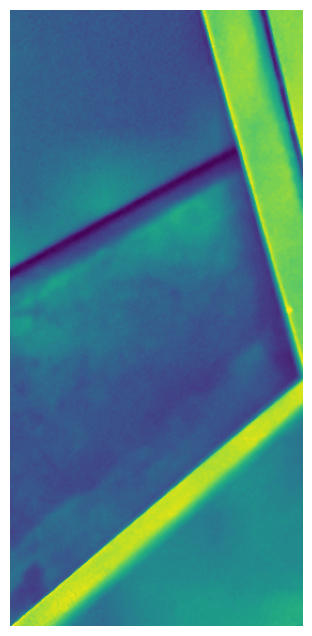

{'bbox': (1089, 509, 383, 144), 'fill_score': 0.003168779180839261, 'label': ''}
{'bbox': (1793, 627, 229, 187), 'fill_score': 0.00583799560730237, 'label': ''}
{'bbox': (921, 238, 1152, 87), 'fill_score': 0.007446940539348467, 'label': ''}
{'bbox': (471, 1224, 100, 374), 'fill_score': 0.008771929728377963, 'label': ''}
{'bbox': (1196, 1163, 816, 415), 'fill_score': 0.016261021048243472, 'label': ''}


In [24]:
# Visualize
vis = image_rgb.copy()
bin_data = sorted(bin_data, key=lambda b: b["fill_score"])  # sort by emptiest first
for b in bin_data[:1]:
    x, y, w, h = b["bbox"]
    color = (0, 255, 0) if b["fill_score"] > 0.02 else (255, 0, 0)  # green = full, blue = empty
    cv2.rectangle(vis, (x, y), (x+w, y+h), color, 2)
    
    cv2.putText(vis, b["label"][:15], (x, y-5), cv2.FONT_HERSHEY_SIMPLEX,
                0.5, (255, 0, 0), 1)

plt.figure(figsize=(12, 8))
plt.imshow(roi_gray)
plt.axis("off")
plt.show()

for b in bin_data[:5]:
    print(b)


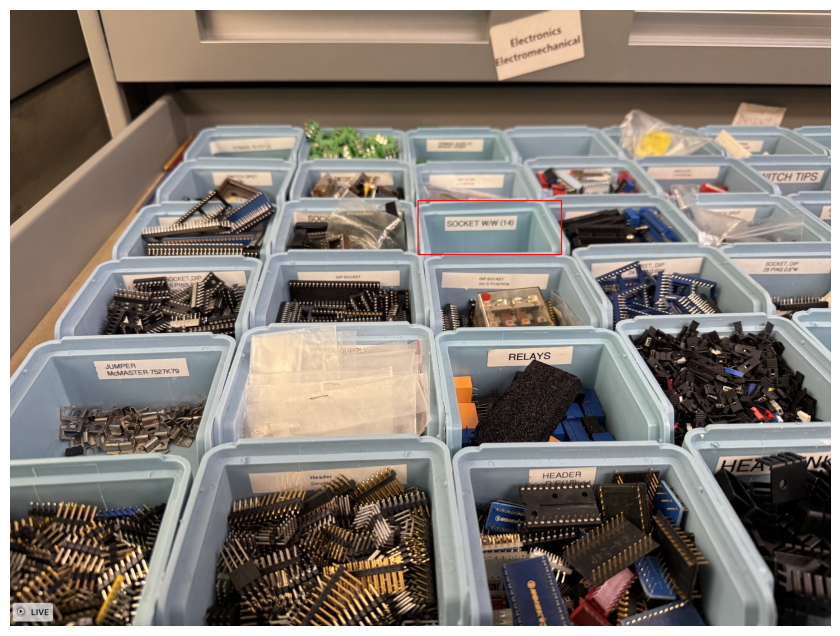

Label: LRTET I Ve -, Fill score: 0.000
Label: Ly s ae TR e SRR RS> E, Fill score: 0.000
Label: P, Fill score: 0.000
Label: A 7L, Fill score: 0.000
Label: o R g e —————— Y S A, Fill score: 0.000


In [25]:
import cv2
import pytesseract
import numpy as np

def compute_fill_score(c, gray_img):
    mask = np.zeros(gray_img.shape, np.uint8)
    cv2.drawContours(mask, [c], -1, 255, -1)
    edges = cv2.Canny(gray_img, 50, 150)
    edge_density = cv2.countNonZero(cv2.bitwise_and(edges, edges, mask=mask))
    area = cv2.contourArea(c) + 1e-5
    return edge_density / area

# Load image
img = cv2.imread("drawer.png")
output = img.copy()
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Threshold to detect white labels
_, th = cv2.threshold(gray, 200, 255, cv2.THRESH_BINARY)
contours, _ = cv2.findContours(th, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

bin_scores = []

for cnt in contours:
    x, y, w, h = cv2.boundingRect(cnt)

    if w > 60 and 15 < h < 50:  # heuristic for label
        label_crop = img[y:y+h, x:x+w]
        text = pytesseract.image_to_string(label_crop, config="--psm 7").strip()

        if text:
            # Define bin region below label
            bin_region = img[y+h:y+h+120, x:x+w]
            bin_gray = cv2.cvtColor(bin_region, cv2.COLOR_BGR2GRAY)

            # Compute contour for the bin rectangle
            bin_cnt = np.array([[[x, y+h]], [[x+w, y+h]], [[x+w, y+h+120]], [[x, y+h+120]]])

            score = compute_fill_score(bin_cnt, bin_gray)

            bin_scores.append({
                "label": text,
                "score": score,
                "coords": (x, y+h, w, 120)
            })

# Sort by score (lowest = emptiest)
bin_scores = sorted(bin_scores, key=lambda b: b["score"])[:5]

# Draw only top-5 emptiest bins
for b in bin_scores:
    x, y, w, h = b["coords"]
    cv2.rectangle(output, (x, y), (x+w, y+h), (0, 0, 255), 2)
    cv2.putText(output, f"{b['label']} ({b['score']:.3f})",
                (x, y+h+20), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 255), 2)

plt.figure(figsize=(12, 8))
plt.imshow(vis)
plt.axis("off")
plt.show()

# Also print them
for b in bin_scores:
    print(f"Label: {b['label']}, Fill score: {b['score']:.3f}")

